In [8]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt

# класс из файла mlp_class.py
from mlp_class import NET
from preprocessing import *

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, \
                            recall_score, f1_score, roc_auc_score

### READ

In [9]:
# https://www.kaggle.com/ronitf/heart-disease-uci
data = pd.read_csv('heart.csv')

In [10]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [11]:
data.shape

(303, 14)

In [12]:
data['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

In [13]:
# предобработка
prepr_train = preproc_func(data.copy()).reset_index(drop=True)

## CLASS

In [197]:
class GA():
    
    def __init__ (self, X, y, params, metric, min_iter, max_iter, stop_delta, \
                  thr_delta, N, n_epoch, eps, eta, parent_num, outbreed_freq, threshold, eletism):
        self.params = params
        self.metric = metric
        self.min_iter = min_iter
        self.max_iter = max_iter
        self.stop_delta = stop_delta
        self.thr_delta = thr_delta
        self.N = N
        self.parent_num = parent_num
        self.outbreed_freq = outbreed_freq
        
        self.X = X
        self.y = y
        
        self.n_epoch = n_epoch 
        self.eps = eps
        self.eta = eta
        
        self.stop_flg = 0
        # номер поколения
        self.i = 0
        
        self.cum_metrics = [0]
        # веса, с которыми учитываем близость особей при выборе родителей (взяты из головы)
        self.weights  = np.array([1.3, 0.5])
        self.threshold = threshold
        self.eletism = eletism
        
        #вероятность мутации гена 
        self.p_mutation = 0.3
        
        self.population = pd.DataFrame([])

    # получение случайных значений из словаря dict_ по каждому ключу
    def get_params(self):   
        tmp_params = {}
        for key, value in self.params.items():
            tmp_params[key] = random.choice(value)    
        return tmp_params

    # категоризация параметров из словаря params, у которых тип float или string
    def param_categorizing(self):
        params_cats = {}
        len_of_gen = []

        for key, value in self.params.items():

            # параметр num_of_hidden нам не требуется категоризовать
            if key == 'num_of_hidden':
                len_of_gen.append(len(bin(max(value))[2:]))   
                params_cats[key] = []
            else:
                if len(value) < 10:
                    # число элементов в бакете
                    n_in_bucket = 1
                    # на сколько бакетов бъем список
                    n_buckets   = len(value)
                else:
                    bucket_size = 0.1
                    # число элементов в бакете
                    n_in_bucket = round(len(value) * bucket_size)
                    # на сколько бакетов бъем список
                    n_buckets = round(len(value) / n_in_bucket)

                len_of_gen.append(len(bin(n_buckets)[2:]))
                cats = [[(xx, x) for xx in value[x * n_in_bucket : x * n_in_bucket + n_in_bucket]] for x in range(n_buckets)]
                flat_cats = dict([item for sublist in cats for item in sublist])
                params_cats[key] = flat_cats
        
        self.map_dict = params_cats
        self.cat_keys = list(self.map_dict.keys())
        self.len_of_gen = max(len_of_gen)
        
    # функция для обучения
    def train(self, tmp_params):

        X_train, X_valid, y_train, y_valid = train_test_split(self.X, 
                                                              self.y, 
                                                              test_size=tmp_params['valid_size'],
                                                              random_state=1)
        model = NET(epoch=self.n_epoch,
                    eps=self.eps,
                    eta=self.eta,
                    hidden = tmp_params['num_of_hidden'],
                    func_hidden = tmp_params['func_hidden'],
                    func_out = tmp_params['func_out'],
                    build_graph=False
                   )
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_valid = model.predict(X_valid)
        return y_train, y_valid, pred_train, pred_valid

    # функция для оценки качества классификации
    def evaluate(self, y_true, y_pred):
        accur = accuracy_score(y_true, y_pred)
        balanced_accur = balanced_accuracy_score(y_true, y_pred)
        prc = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        return accur, balanced_accur, prc, rec, f1

    def stop_criteria(self, population, num_of_generation):
        pop_tmp = population.copy()
        # критерий остановки 
        if ((num_of_generation >= self.min_iter) and \
           (pop_tmp[self.metric].max() >= max(self.cum_metrics)) and \
           (pop_tmp[self.metric].max() - self.cum_metrics[-1] < self.stop_delta)) \
             or \
           (num_of_generation > self.max_iter):
            self.stop_flg = 1
        self.cum_metrics.append(round(pop_tmp[self.metric].max(),5))


    #обучение + оценка особей
    def evaluate_population(self, curr_population, num_of_generation):
        individs = curr_population.copy()
        generation = {}
        for i in range(len(individs)):
            generation[i] = {}
            generation[i]['num_of_generation'] = num_of_generation
            # записываем параметры для данной особи в виде словаря
            tmp_params = individs[i]
            generation[i]['params'] = tmp_params
            # записываем параметры особи в виде отдельных столбцов
            for key, value in tmp_params.items():
                generation[i][key] = value
            # fit + predict
            y_train, y_valid, pred_train, pred_valid = self.train(tmp_params)
            # evaluate
            accur, balanced_accur, prc, rec, f1 = self.evaluate(y_valid, pred_valid)
            # записываем в словарь population_child данные по качеству каждой особи
            generation[i]['accuracy_score'] = accur
            generation[i]['balanced_accuracy_score'] = balanced_accur
            generation[i]['precision_score'] = prc
            generation[i]['recall_score'] = rec
            generation[i]['f1_score'] = f1
        return pd.DataFrame.from_dict(generation, orient='index')

    # кодирование особи
    def individ_encoding(self, individ):
        
        encoded_individ = {}
        for key in self.cat_keys:
            individ_param = individ[key]
            if key != 'num_of_hidden':
                individ_param_cat = self.map_dict[key][individ_param]
            else:
                individ_param_cat = individ_param

            # бинаризация
            encoded_param = bin(individ_param_cat)[2:]
            new_param = []

            # дописываем в нначало нули, если требуется
            if len(encoded_param) < self.len_of_gen:
                new_param = ['0']*(self.len_of_gen - len(encoded_param))
                new_param.append(encoded_param)
                new_param = ''.join(new_param)
            else:
                new_param = encoded_param

            encoded_individ[key] = new_param

        param_string = []
        for key, value in encoded_individ.items():
            param_string.append(value)
        param_string = ''.join(param_string)

        return param_string

    # декодирование особи
    def individ_decoding(self, individ):
        splited = [individ[x*self.len_of_gen:x*self.len_of_gen+self.len_of_gen] \
                   for x in range(len(self.cat_keys))]
        decoded = [int(x, 2) for x in splited]
        decoded_individ = {}
        for key, value in zip(self.cat_keys, decoded):
            param_cat = None
            if key != 'num_of_hidden':
                keys_to_chose = []
                for k, v in self.map_dict[key].items():
                    if v == value:
                        keys_to_chose.append(k)
                    else:
                        pass
                param_cat = random.choice(keys_to_chose)     
            else:
                param_cat = value

            decoded_individ[key] = param_cat
        return decoded_individ
    
    #бинарное расстояние хэмминга
    def bin_hamming(self, x, y):
        return sum(c1 != c2 for c1, c2 in zip(x, y))
    
    #мутация потомков
    def mutation(self, individ):
        #(00000+++,++++++++,000000++,000000++)
        #генерим разные маски
        m1=random.randrange(1,7,1)
        m2=random.randrange(1,256,1)
        m3=random.randrange(1,3,1)
        m4=random.randrange(1,3,1)
        out1=bin(int(individ[0],2)|m1)
        out2=bin(int(individ[1],2)|m2)
        out3=bin(int(individ[2],2)|m3)
        out4=bin(int(individ[3],2)|m4)
        return out1,out2,out3,out4
    
    #формирование пар родителей 
    def parent_choise(self, curr_pop):
        generation = curr_pop.copy().reset_index(drop=True)
        parents  = []
        individs = generation['encoded_individ']
        metrics  = generation[self.metric]
        #создаём изначально установленное количество родителей
        for i in range(self.parent_num):
            #случайно выбираем первого родителя
            parent_1 = random.choice(generation.index) 
            #смотрим по всем оставшимся особям
            for parent_tmp in range(self.parent_num):
                if parent_tmp != parent_1:
                    #рассчитываем бинарное расстояние Хэммнига для первого(случайного) родителя и второго(из цикла)
                    ham_dist = self.bin_hamming(individs[parent_1], individs[parent_tmp])
                    #разницу по выбранной метрике
                    met_dist = abs(metrics[parent_1] - metrics[parent_tmp])
                    #взвешенная оценка по метрике и расстоянию Хэмминга 
                    weight_avg = np.average(np.array([ham_dist, met_dist]), weights=self.weights)
                    if parent_tmp == 0:
                        #заполняем изначальное значение для минимальной взвешенной оценки
                        min_avg = weight_avg
                        #если аутбридинг или инбридинг (outbreed_freq-число обозначающее на какой итерации должен быть аутбридинг)
                    if ((i+1) % self.outbreed_freq == 0 and min_avg <= weight_avg) \
                        or \
                       ((i+1) % self.outbreed_freq != 0 and min_avg >= weight_avg):
                        #обозначаем родителя, заполняем минимальную оценку
                        parent_2 = parent_tmp
                        min_avg = weight_avg
                else:
                    min_avg = len(individs[parent_1])
            #добавляем полученных родителей
            parents.append([individs[parent_1], individs[parent_2]])
        return parents
    
    # функция рекомбинации (формирование детей по заданным парам родителей)
    def recombination(self, parents):
        children = {}
        num_of_params = len(self.cat_keys)
        n = self.len_of_gen
        for i in range (len(parents)):
            child = []
            schema = ''.join(random.choice('01') for i in range(num_of_params))

            parent_1 = [parents[i][0][x*n:x*n+n] for x in range(num_of_params)]
            parent_2 = [parents[i][1][x*n:x*n+n] for x in range(num_of_params)]

            for gen_choise in range(len(schema)):
                if schema[gen_choise] == '0':
                    child.append(parent_1[gen_choise])
                else:
                    child.append(parent_2[gen_choise])
            #проводим мутацию, если проводим 
            p_mut = random.random()
            if p_mut < self.p_mutation: 
                self.mutation(child)
            children[i] = self.individ_decoding(individ=''.join(child))
        return children
    
    # функция для отбора в новую популяцию
    def selection(self, population, num_of_generation, thr):
        pop = population.copy()
        n_elitism = int(self.N * self.eletism)
        population_input = pop[pop['num_of_generation'] == num_of_generation-1]
        # методом элитизма выбираем 10 процентов лучших
        population_output = population_input.sort_values(by=self.metric, ascending=False).head(n_elitism)
        # исключаем из рассмотрения 
        population_input = population_input.sort_values(by=metric, ascending=False)[n_elitism + 1:self.N]
        # методом отсечения выбираем оставшиеся члены популяции
        thr_avg = np.average(population_input[self.metric])
        selected_individs = population_input[(population_input[self.metric] >= thr_avg*(1-thr)) | (population_input[self.metric]<=thr_avg*(1+thr))].reset_index(drop=True)
        cnt = selected_individs.shape[0]
        iteration = self.N - n_elitism
        for j in range(iteration):
            i = np.random.choice(range(cnt))
            population_output = population_output.append(selected_individs.iloc[i,:])
        # номер итерации алгоритма
        population_output['num_of_generation'] = num_of_generation
        return population_output
    
    
    def run_generation(self, population, num_of_generation):
        if num_of_generation != 0:
            pop = population.copy()
            pop = pop[pop['num_of_generation'] == num_of_generation-1]
            # формируем пары родителей
            parents = self.parent_choise(pop)
            # формируем детей
            new_individs = self.recombination(parents)
            # получаем результаты обучения полученных "детей" (1 ребенок = 1 нейронная сеть)
            curr_pop = self.evaluate_population(new_individs, num_of_generation-1)
        else:
            pop = population.copy()
            # формируем первоначальную популяцию, выбирая случайным образом параметры особей из словаря params
            new_individs = {}
            for i in range(self.N):
                new_individs[i] = self.get_params()
            # получаем результаты обучения полученной популяции
            curr_pop = self.evaluate_population(new_individs, num_of_generation)
            self.stop_criteria(curr_pop, num_of_generation)
        # кодируем особь
        curr_pop['encoded_individ'] = curr_pop[self.cat_keys].apply(lambda x: self.individ_encoding(x), axis = 1)
        if num_of_generation != 0:
            #объединение детей и родителей
            population_to_select = pop.append(curr_pop)
            # отбор в новую популяцию
            self.threshold = max(self.cum_metrics) - self.thr_delta
            self.thr_delta = min([self.thr_delta, max(self.cum_metrics) - max([x for x in self.cum_metrics if x!=max(self.cum_metrics)]) + 0.005])
            selected = self.selection(population_to_select, num_of_generation, thr=self.threshold)
            # проверяем критерий остановки
            self.stop_criteria(selected, num_of_generation)
            return selected
        else: 
            return curr_pop
    
    
    def fit(self):
        
        self.param_categorizing()
        
        while not(self.stop_flg):
            print('population {}'.format(self.i))
            new_pop = self.run_generation(self.population, num_of_generation=self.i)
            print(self.cum_metrics)
            print(self.stop_flg)
            #добавление полученной популяции в общий df
            self.population = self.population.append(new_pop).reset_index(drop=True)
            self.population.to_excel("population.xlsx")
            self.i += 1

## TRAIN

In [188]:
quality_type = input("Choose a quality metric\n1)accuracy score\n2)balanced accuracy score\n3)precision score\n4)recall score\n5)f1 score\n\n")or '5'
parent_num = int(input(f"Enter the number of pairs of parents (default=20)\n\n") or 20)
outbreed_freq = int(input("Enter the outbreeding frequency(defalut=7)\n\n") or 7)

Choose a quality metric
1)accuracy score
2)balanced accuracy score
3)precision score
4)recall score
5)f1 score


Enter the number of pairs of parents (default=20)


Enter the outbreeding frequency(defalut=7)




In [189]:
metrics = {
    '1':'accuracy_score',
    '2':'balanced_accuracy_score',
    '3':'precision_score',
    '4':'recall_score',
    '5':'f1_score',
    }

metric = metrics[quality_type]
metric

'f1_score'

In [190]:
X = prepr_train.drop('target', axis=1)
y = prepr_train['target']

In [191]:
# количество фактов обучающей выборки
F = data.shape[0]
# количество входов сети
I = data.shape[1]
# количество выходов сети
O = data['target'].nunique()

a = round(F/10-I-O)
b = round(F/2-I-O)

In [192]:
if a > 1:
    num_of_hidden = range(a, b, 1)
else:
    a = round(0)
    num_of_hidden = range(round(F*0.5), round(F*0.9), 1)

params = {
        #размер отложенной выборки для валидации
        'valid_size': [float(x) for x in list(np.arange(0.1, 0.3, 0.0001))],
        #число нейронов на скрытом слое, доля от k
        'num_of_hidden' : num_of_hidden, #границы a и b получаем по формуле выше
        #функция активации на скрытом слое
        'func_hidden' : ['sigm', 'tanh'],  
        #функция активации на выходном слое
        'func_out' : ['sigm', 'tanh']  
}

In [193]:
nn_ga = GA(X=X,
           y=y,
           params=params,
           metric=metric,
           min_iter=10,
           max_iter=500,
           stop_delta=0.00001,
           thr_delta=0.05,
           N=20,
           n_epoch=40,
           eps=20,
           eta=0.5,
           parent_num=parent_num,
           outbreed_freq=outbreed_freq,
           threshold=0.2,
           eletism=0.1
          )

In [194]:
nn_ga.fit() 

population 0
[0, 0.90909]
0
population 1
[0, 0.90909, 0.90909]
0
population 2
[0, 0.90909, 0.90909, 0.90909]
0
population 3
[0, 0.90909, 0.90909, 0.90909, 0.91892]
0
population 4
[0, 0.90909, 0.90909, 0.90909, 0.91892, 0.91892]
0
population 5
[0, 0.90909, 0.90909, 0.90909, 0.91892, 0.91892, 0.92308]
0
population 6
[0, 0.90909, 0.90909, 0.90909, 0.91892, 0.91892, 0.92308, 0.95]
0
population 7
[0, 0.90909, 0.90909, 0.90909, 0.91892, 0.91892, 0.92308, 0.95, 0.95]
0
population 8
[0, 0.90909, 0.90909, 0.90909, 0.91892, 0.91892, 0.92308, 0.95, 0.95, 0.95]
0
population 9
[0, 0.90909, 0.90909, 0.90909, 0.91892, 0.91892, 0.92308, 0.95, 0.95, 0.95, 0.95]
0
population 10
[0, 0.90909, 0.90909, 0.90909, 0.91892, 0.91892, 0.92308, 0.95, 0.95, 0.95, 0.95, 0.95]
1


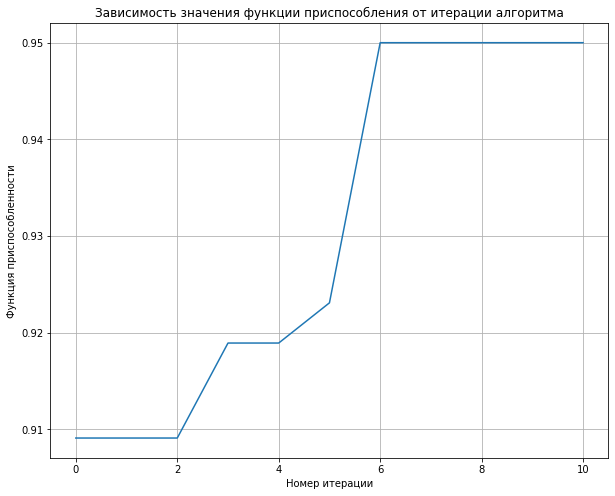

In [195]:
plt.figure(figsize=(10,8))
plt.plot(nn_ga.cum_metrics[1:]);
plt.grid();
plt.title('Зависимость значения функции приспособления от итерации алгоритма');
plt.xlabel('Номер итерации');
plt.ylabel('Функция приспособленности');

###### Troubles:

1. Проверка на допустимость решения (ну пока не требуется)
2. Как изменять threshold
3. От каких параметров может зависить сходимость? (построить графики)
    - trh_delta
    - N
    - num_of_generations
4. Проверка входных данных (защита от дурака)